<a href="https://colab.research.google.com/github/captainkeemo/Dysarthric-Speech-Transcription/blob/main/models/base_CTC_RNNT_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install jiwer editdistance --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import torch
import torchaudio
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from jiwer import wer, cer
import editdistance
import glob
from tqdm import tqdm
import torch.nn.functional as F
from tqdm.auto import tqdm
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import random_split

In [4]:
from torch.cuda.amp import autocast, GradScaler
scaler_ctc = GradScaler()
scaler_rnnt = GradScaler()

<ipython-input-4-ae68ad2b3aa0>:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_ctc = GradScaler()
<ipython-input-4-ae68ad2b3aa0>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_rnnt = GradScaler()


In [5]:
# Define vocabulary
vocab = list("abcdefghijklmnopqrstuvwxyz '") + ["|"]
char_to_index = {c: i for i, c in enumerate(vocab)}
index_to_char = {i: c for c, i in char_to_index.items()}


In [6]:
def clean_transcription(text):
    text = text.lower().strip()
    if '.jpg' in text or '[say' in text or text == 'xxx' or text == '':
        return None
    return text

def decode_sequence(indices, index_to_char):
    return ''.join([index_to_char.get(i, '') for i in indices]).replace('|', '').strip()

In [7]:
# Function to get the device
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# Preprocessing Mel spectrograms
def preprocess_and_save_mel(root_dir, save_dir, sample_rate=16000, n_mels=80, use_gpu=False):
    os.makedirs(save_dir, exist_ok=True)

    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=n_mels).to(device)
    resampler = torchaudio.transforms.Resample(orig_freq=48000, new_freq=sample_rate).to(device)

    # Step 1: Gather .wav files with tqdm
    print("Scanning for .wav files...")
    wav_paths = []
    for dirpath, _, filenames in tqdm(os.walk(root_dir), desc="Scanning folders"):
        for fname in filenames:
            if fname.endswith('.wav') and 'wav_headMic' in dirpath:
                wav_paths.append(os.path.join(dirpath, fname))

    print(f"Found {len(wav_paths)} .wav files. Starting preprocessing...")

    total_saved = 0

    # Step 2: Preprocess with tqdm
    for wav_path in tqdm(wav_paths, desc="Preprocessing Mel Spectrograms"):
        mel_path = os.path.join(save_dir, os.path.basename(wav_path).replace('.wav', '.pt'))
        txt_path = wav_path.replace('wav_headMic', 'prompts').replace('.wav', '.txt')

        if not os.path.exists(txt_path) or os.path.exists(mel_path):
            continue

        try:
            waveform, sr = torchaudio.load(wav_path)
            waveform = waveform.to(device)

            if sr != sample_rate:
                waveform = resampler(waveform)

            mel_spec = mel_transform(waveform).squeeze(0).transpose(0, 1).cpu()

            with open(txt_path, 'r', encoding='utf-8') as f:
                transcript = f.read().strip().lower()

            if '.jpg' in transcript or transcript in ('xxx', '') or '[say' in transcript:
                continue

            torch.save((mel_spec, transcript), mel_path)
            total_saved += 1
        except Exception as e:
            print(f"Error processing {wav_path}: {e}")

    print(f"\nDone: {total_saved} mel .pt files saved to {save_dir}")


In [9]:
'''
preprocess_and_save_mel(
    root_dir="/content/drive/MyDrive/TORGO",
    save_dir="/content/drive/MyDrive/TORGO_mel_preprocessed"
)
'''

'\npreprocess_and_save_mel(\n    root_dir="/content/drive/MyDrive/TORGO",\n    save_dir="/content/drive/MyDrive/TORGO_mel_preprocessed"\n)\n'

In [10]:
class TorgoDataset(Dataset):
    def __init__(self, root_dir, char_to_index, sample_rate=16000,
                 items_file=None, use_precomputed=False, mel_dir=None):
        self.char_to_index = char_to_index
        self.sample_rate = sample_rate
        self.use_precomputed = use_precomputed
        self.items = []

        if self.use_precomputed:
            assert mel_dir is not None, "If using precomputed features, you must provide mel_dir."
            self.paths = sorted([
                os.path.join(mel_dir, f)
                for f in os.listdir(mel_dir) if f.endswith('.pt')
            ])
        else:
            self.mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=80)
            self.resampler = torchaudio.transforms.Resample(orig_freq=48000, new_freq=sample_rate)

            if items_file is not None:
                loaded_items = torch.load(items_file)
                for wav_fp, text in loaded_items:
                    cleaned = clean_transcription(text)
                    if cleaned:
                        self.items.append((wav_fp, cleaned))
            else:
                wav_files = []
                for dirpath, _, filenames in os.walk(root_dir):
                    for fname in filenames:
                        if fname.endswith('.wav') and 'wav_headMic' in dirpath:
                            wav_files.append(os.path.join(dirpath, fname))

                for wav_fp in tqdm(wav_files, desc=f"Building dataset from .wav files ({len(wav_files)} found)"):
                    txt_fp = wav_fp.replace('wav_headMic', 'prompts').replace('.wav', '.txt')
                    if not os.path.exists(txt_fp):
                        continue
                    with open(txt_fp, 'r', encoding='utf-8') as f:
                        text = f.read()
                    cleaned = clean_transcription(text)
                    if cleaned:
                        self.items.append((wav_fp, cleaned))

    def __len__(self):
        return len(self.paths) if self.use_precomputed else len(self.items)

    def __getitem__(self, idx):
        if self.use_precomputed:
            mel_path = self.paths[idx]
            mel_spec, transcript = torch.load(mel_path)
        else:
            wav_path, transcript = self.items[idx]
            waveform, sr = torchaudio.load(wav_path)
            if sr != self.sample_rate:
                waveform = self.resampler(waveform)
            mel_spec = self.mel_transform(waveform).squeeze(0).transpose(0, 1)

        target = torch.tensor([self.char_to_index[c] for c in transcript if c in self.char_to_index], dtype=torch.long)
        return mel_spec, target


In [11]:
def collate_fn(batch):
    features, targets = zip(*batch)

    # Compute original lengths
    input_lengths = torch.tensor([feat.size(0) for feat in features], dtype=torch.long)
    target_lengths = torch.tensor([len(tgt) for tgt in targets], dtype=torch.long)

    # Pad features (time dimension is dim 0)
    padded_features = pad_sequence(features, batch_first=True)  # shape: [B, T, F]

    # Pad targets for inspection (not used in loss)
    padded_targets = pad_sequence(targets, batch_first=True, padding_value=0)

    return padded_features, input_lengths, padded_targets, target_lengths


In [12]:
# Define the full RNN-T model with encoder, decoder, and joiner
class RNNTModel(nn.Module):
    def __init__(self, input_dim=80, vocab_size=len(vocab), hidden_dim=128, embed_dim=64):
        super().__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.decoder = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.joiner = nn.Linear(hidden_dim * 2 + hidden_dim, vocab_size)  # enc (bi) + dec (uni)

    def forward(self, encoder_input, target_input):
        # encoder_input: [B, T_enc, 80]
        # target_input: [B, T_dec]
        enc_out, _ = self.encoder(encoder_input)  # [B, T_enc, 2*H]
        dec_emb = self.embed(target_input)        # [B, T_dec, E]
        dec_out, _ = self.decoder(dec_emb)        # [B, T_dec, H]

        # Expand for joiner broadcasting
        enc_exp = enc_out.unsqueeze(2)            # [B, T_enc, 1, 2H]
        dec_exp = dec_out.unsqueeze(1)            # [B, 1, T_dec, H]

        # Joiner: concat and project
        enc_b, t_enc, _, h_enc = enc_exp.shape
        dec_b, _, t_dec, h_dec = dec_exp.shape
        assert enc_b == dec_b

        enc_rep = enc_exp.expand(-1, t_enc, t_dec, -1)  # [B, T_enc, T_dec, 2H]
        dec_rep = dec_exp.expand(-1, t_enc, t_dec, -1)  # [B, T_enc, T_dec, H]

        joined = torch.cat([enc_rep, dec_rep], dim=-1)  # [B, T_enc, T_dec, 3H]
        logits = self.joiner(joined)                    # [B, T_enc, T_dec, V]
        return logits


In [13]:
# CTC Model Class
class CTCModel(nn.Module):
    def __init__(self, input_dim=80, hidden_dim=128, vocab_size=len(vocab), num_layers=2, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)

    def forward(self, x):
        x, _ = self.lstm(x)
        logits = self.fc(x)
        return logits  # shape: [B, T, vocab_size]


In [14]:
class BeamSearch:
    def __init__(self, beam_width, vocab_size, blank_index):
        self.beam_width = beam_width
        self.vocab_size = vocab_size
        self.blank_index = blank_index

    def decode(self, logits):
        batch_size = logits.size(1)
        T = logits.size(0)
        results = []

        for b in range(batch_size):
            beams = [([], 0.0)]
            for t in range(T):
                new_beams = []
                log_probs = F.log_softmax(logits[t, b], dim=-1)
                topk = torch.topk(log_probs, self.beam_width)

                for seq, score in beams:
                    for i in range(self.beam_width):
                        token = topk.indices[i].item()
                        new_score = score + topk.values[i].item()
                        if token == self.blank_index:
                            new_beams.append((seq, new_score))
                        else:
                            new_beams.append((seq + [token], new_score))

                new_beams.sort(key=lambda x: x[1], reverse=True)
                beams = new_beams[:self.beam_width]

            best_seq = max(beams, key=lambda x: x[1])[0]
            results.append(best_seq)  # Changed from results.append([best_seq])

        # Ensure results is always a list of lists even with beam_width=1
        results = [[item] if isinstance(item, int) else item for item in results]

        return results

In [15]:
# Compute WER, CER, Edit Distance
from torchaudio.functional import edit_distance as torchaudio_edit_distance
from jiwer import wer, cer

def compute_wer_cer(preds, input_lens, targets, target_lens, index_to_char):
    total_wer, total_cer = 0.0, 0.0
    offset = 0
    valid_examples = 0

    for i in range(len(preds)):
        tlen = target_lens[i].item()
        if tlen == 0:
            continue  # skip empty targets

        target_slice = targets[offset:offset + tlen]
        target_seq = target_slice.view(-1).tolist()
        offset += tlen

        pred_seq = preds[i] if isinstance(preds[i], (list, tuple)) else [preds[i]]
        pred_str = ''.join([index_to_char.get(p, '') for p in pred_seq])
        target_str = ''.join([index_to_char.get(t, '') for t in target_seq])

        if not target_str.strip():
            continue  # skip if the reference string is still empty

        total_wer += wer(target_str, pred_str)
        total_cer += cer(target_str, pred_str)
        valid_examples += 1

    if valid_examples == 0:
        return 1.0, 1.0  # fallback if no valid examples
    return total_wer / valid_examples, total_cer / valid_examples



In [16]:
from jiwer import cer

def decode_indices(indices, index_to_char):
    return ''.join([index_to_char[i] for i in indices if i in index_to_char]).replace('|', ' ').strip()

def compute_cer_accuracy(preds, targets, target_lens, index_to_char):
    offset = 0
    all_refs, all_hyps = [], []
    for i, tlen in enumerate(target_lens):
        ref = ''.join([index_to_char[x.item()] for x in targets[offset:offset + tlen]])
        hyp = ''.join([index_to_char[x] for x in preds[i]])
        all_refs.append(ref)
        all_hyps.append(hyp)
        offset += tlen
    return 1.0 - cer(all_refs, all_hyps)


In [17]:
# Greedy decoding for character prediction from model output
def greedy_decode(logits, input_lens, blank_index):
    pred = logits.argmax(dim=2)
    results = []
    for i in range(pred.size(0)):
        tokens, prev = [], None
        for j in range(input_lens[i]):
            idx = pred[i, j].item()
            if idx != blank_index and idx != prev:
                tokens.append(idx)
            prev = idx
        results.append(tokens)
    return results

In [18]:
from tqdm import tqdm

def train_ctc(model, train_loader, val_loader, optimizer, loss_fn, index_to_char,
              device, epochs=20, patience=5, blank_idx=1, beam_width=5):

    model.to(device)
    best_val_loss = float('inf')
    wait = 0

    train_loss_hist, val_loss_hist = [], []
    train_wer_hist, val_wer_hist = [], []
    train_cer_hist, val_cer_hist = [], []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        model.train()
        train_loss, train_wer, train_cer = 0, 0, 0

        train_bar = tqdm(train_loader, desc="Training", leave=False)
        for feats, feat_lens, targets, target_lens in train_bar:
            feats, feat_lens = feats.to(device), feat_lens.to(device)
            targets, target_lens = targets.to(device), target_lens.to(device)

            optimizer.zero_grad()
            logits = model(feats)
            log_probs = logits.log_softmax(2).transpose(0, 1)
            loss = loss_fn(log_probs, targets, feat_lens, target_lens)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            with torch.no_grad():
                decoder = BeamSearch(beam_width, logits.size(2), blank_idx)
                raw_preds = decoder.decode(log_probs.cpu())

                preds = [beam[0] if isinstance(beam[0], (list, tuple)) else beam for beam in raw_preds]
                preds = [p if isinstance(p, list) else [p] for p in preds]

                wer_score, cer_score = compute_wer_cer(preds, feat_lens.cpu(), targets.cpu(), target_lens.cpu(), index_to_char)
                train_wer += wer_score
                train_cer += cer_score

            train_bar.set_postfix(loss=loss.item(), WER=wer_score, CER=cer_score)

        train_loss /= len(train_loader)
        train_wer /= len(train_loader)
        train_cer /= len(train_loader)

        # --- Validation ---
        model.eval()
        val_loss, val_wer, val_cer = 0, 0, 0
        val_bar = tqdm(val_loader, desc="Validating", leave=False)
        with torch.no_grad():
            for feats, feat_lens, targets, target_lens in val_bar:
                feats, feat_lens = feats.to(device), feat_lens.to(device)
                targets, target_lens = targets.to(device), target_lens.to(device)

                logits = model(feats)
                log_probs = logits.log_softmax(2).transpose(0, 1)
                loss = loss_fn(log_probs, targets, feat_lens, target_lens)
                val_loss += loss.item()

                decoder = BeamSearch(beam_width, logits.size(2), blank_idx)
                raw_preds = decoder.decode(log_probs.cpu())

                preds = [beam[0] if isinstance(beam[0], (list, tuple)) else beam for beam in raw_preds]
                preds = [p if isinstance(p, list) else [p] for p in preds]

                wer_score, cer_score = compute_wer_cer(preds, feat_lens.cpu(), targets.cpu(), target_lens.cpu(), index_to_char)
                val_wer += wer_score
                val_cer += cer_score

                val_bar.set_postfix(loss=loss.item(), WER=wer_score, CER=cer_score)

        val_loss /= len(val_loader)
        val_wer /= len(val_loader)
        val_cer /= len(val_loader)

        train_loss_hist.append(train_loss)
        val_loss_hist.append(val_loss)
        train_wer_hist.append(train_wer)
        val_wer_hist.append(val_wer)
        train_cer_hist.append(train_cer)
        val_cer_hist.append(val_cer)

        print(f"[CTC] Epoch {epoch+1}: "
              f"Train Loss={train_loss:.4f}, WER={train_wer:.4f}, CER={train_cer:.4f} | "
              f"Val Loss={val_loss:.4f}, WER={val_wer:.4f}, CER={val_cer:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), '/content/drive/MyDrive/best_ctc_model.pt')
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping.")
                break

    return train_loss_hist, val_loss_hist, train_wer_hist, val_wer_hist, train_cer_hist, val_cer_hist


In [19]:
from tqdm import tqdm

def train_rnnt(model, train_loader, val_loader, optimizer, loss_fn, index_to_char,
               device, epochs=20, patience=5, blank_idx=1, beam_width=5):

    model.to(device)
    best_val_loss = float('inf')
    wait = 0

    train_loss_hist, val_loss_hist = [], []
    train_wer_hist, val_wer_hist = [], []
    train_cer_hist, val_cer_hist = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, train_wer, train_cer = 0, 0, 0

        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} - Training (RNN-T)")
        for feats, feat_lens, targets, target_lens in train_pbar:
            feats, feat_lens = feats.to(device), feat_lens.to(device)
            targets, target_lens = targets.to(device), target_lens.to(device)

            optimizer.zero_grad()
            logits = model(feats, targets)
            T_enc = logits.shape[1]
            T_dec = logits.shape[2]
            min_len = min(T_enc, T_dec, feat_lens.max().item())
            logits = logits[:, torch.arange(min_len), torch.arange(min_len), :]
            log_probs = logits.log_softmax(2).transpose(0, 1)
            feat_lens = torch.clamp(feat_lens, max=log_probs.shape[0])

            loss = loss_fn(log_probs, targets, feat_lens, target_lens)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            with torch.no_grad():
                decoder = BeamSearch(beam_width, logits.size(2), blank_idx)
                preds = decoder.decode(log_probs.cpu())
                wer_score, cer_score = compute_wer_cer(preds, feat_lens.cpu(), targets.cpu(), target_lens.cpu(), index_to_char)
                train_wer += wer_score
                train_cer += cer_score

        train_loss /= len(train_loader)
        train_wer /= len(train_loader)
        train_cer /= len(train_loader)

        model.eval()
        val_loss, val_wer, val_cer = 0, 0, 0
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1} - Validation (RNN-T)")
        with torch.no_grad():
            for feats, feat_lens, targets, target_lens in val_pbar:
                feats, feat_lens = feats.to(device), feat_lens.to(device)
                targets, target_lens = targets.to(device), target_lens.to(device)

                logits = model(feats, targets)
                T_enc = logits.shape[1]
                T_dec = logits.shape[2]
                min_len = min(T_enc, T_dec, feat_lens.max().item())
                logits = logits[:, torch.arange(min_len), torch.arange(min_len), :]
                log_probs = logits.log_softmax(2).transpose(0, 1)
                feat_lens = torch.clamp(feat_lens, max=log_probs.shape[0])

                loss = loss_fn(log_probs, targets, feat_lens, target_lens)
                val_loss += loss.item()

                decoder = BeamSearch(beam_width, logits.size(2), blank_idx)
                preds = decoder.decode(log_probs.cpu())
                wer_score, cer_score = compute_wer_cer(preds, feat_lens.cpu(), targets.cpu(), target_lens.cpu(), index_to_char)
                val_wer += wer_score
                val_cer += cer_score

        val_loss /= len(val_loader)
        val_wer /= len(val_loader)
        val_cer /= len(val_loader)

        train_loss_hist.append(train_loss)
        val_loss_hist.append(val_loss)
        train_wer_hist.append(train_wer)
        val_wer_hist.append(val_wer)
        train_cer_hist.append(train_cer)
        val_cer_hist.append(val_cer)

        print(f"[RNN-T] Epoch {epoch+1}: Train Loss={train_loss:.4f}, WER={train_wer:.4f}, CER={train_cer:.4f} | "
              f"Val Loss={val_loss:.4f}, WER={val_wer:.4f}, CER={val_cer:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), '/content/drive/MyDrive/best_rnnt_model.pt')
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping.")
                break

    return train_loss_hist, val_loss_hist, train_wer_hist, val_wer_hist, train_cer_hist, val_cer_hist


In [20]:
import matplotlib.pyplot as plt

def evaluate_and_plot_model(
    model,
    test_loader,
    loss_fn,
    index_to_char,
    device,
    blank_idx=1,
    use_beam=True,
    beam_width=5,
    model_type="ctc",
    train_losses=None,
    val_losses=None,
    train_wer=None,
    val_wer=None,
    train_cer=None,
    val_cer=None
):
    model.eval()
    test_loss = 0
    total_wer = 0
    total_cer = 0

    with torch.no_grad():
        for feats, feat_lens, targets, target_lens in test_loader:
            feats, feat_lens = feats.to(device), feat_lens.to(device)
            targets, target_lens = targets.to(device), target_lens.to(device)

            if model_type == "rnnt":
                logits = model(feats, targets)
                T_enc, T_dec = logits.shape[1], logits.shape[2]
                min_len = min(T_enc, T_dec, feat_lens.max().item())
                logits = logits[:, torch.arange(min_len), torch.arange(min_len), :]
            else:
                logits = model(feats)

            log_probs = logits.log_softmax(2).transpose(0, 1)
            feat_lens = torch.clamp(feat_lens, max=log_probs.shape[0])
            loss = loss_fn(log_probs, targets, feat_lens, target_lens)
            test_loss += loss.item()

            decoder = BeamSearch(beam_width, logits.size(2), blank_idx) if use_beam else greedy_decode
            preds = decoder.decode(log_probs.cpu()) if use_beam else decoder(log_probs.cpu().transpose(0, 1), feat_lens.cpu(), blank_idx)

            wer_score, cer_score = compute_wer_cer(preds, feat_lens.cpu(), targets.cpu(), target_lens.cpu(), index_to_char)
            total_wer += wer_score
            total_cer += cer_score

    test_loss /= len(test_loader)
    total_wer /= len(test_loader)
    total_cer /= len(test_loader)

    print(f"[Test – {model_type.upper()}] Loss: {test_loss:.4f} | WER: {total_wer:.4f} | CER: {total_cer:.4f}")

    # === PLOTTING CURVES ===
    if train_losses and val_losses:
        plt.figure(figsize=(8, 5))
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Val Loss")
        plt.title(f"{model_type.upper()} Loss Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

    if train_wer and val_wer:
        plt.figure(figsize=(8, 5))
        plt.plot(train_wer, label="Train WER")
        plt.plot(val_wer, label="Val WER")
        plt.title(f"{model_type.upper()} WER Curve")
        plt.xlabel("Epoch")
        plt.ylabel("WER")
        plt.legend()
        plt.grid(True)
        plt.show()

    if train_cer and val_cer:
        plt.figure(figsize=(8, 5))
        plt.plot(train_cer, label="Train CER")
        plt.plot(val_cer, label="Val CER")
        plt.title(f"{model_type.upper()} CER Curve")
        plt.xlabel("Epoch")
        plt.ylabel("CER")
        plt.legend()
        plt.grid(True)
        plt.show()

    return {
        "test_loss": test_loss,
        "test_wer": total_wer,
        "test_cer": total_cer
    }


In [21]:
# Load data
data_dir = "/content/drive/MyDrive/TORGO"

# Load dataset
#dataset = TorgoDataset(data_dir, char_to_index)
#torch.save(dataset.items, '/content/drive/MyDrive/torgo_items.pt')
dataset = TorgoDataset(
    root_dir="/content/drive/MyDrive/TORGO",  # still required for structure
    char_to_index=char_to_index,
    use_precomputed=True,
    mel_dir="/content/drive/MyDrive/TORGO_mel_preprocessed"
)
print(f"Dataset length: {len(dataset)}")

# Calculate lengths
total_len = len(dataset)
train_len = int(0.7 * total_len)
val_len = int(0.1 * total_len)
test_len = total_len - train_len - val_len

# Perform split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn, pin_memory=True)



Dataset length: 993


In [26]:
import time

# Train CTC model
model_ctc = CTCModel()
optimizer_ctc = torch.optim.Adam(model_ctc.parameters(), lr=1e-5)
loss_fn_ctc = nn.CTCLoss(blank=char_to_index['|'], zero_infinity=True)
device = get_device()

start_time = time.time()
ctc_train_loss, ctc_val_loss, ctc_train_wer, ctc_val_wer, ctc_train_cer, ctc_val_cer = train_ctc(
    model=model_ctc,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_ctc,
    loss_fn=loss_fn_ctc,
    index_to_char=index_to_char,
    epochs=100,
    patience=3,
    device=device
)
end_time = time.time()
print(f"Baseline CTC Training time: {end_time - start_time} seconds")


Epoch 1/100


[CTC] Epoch 1: Train Loss=110.1601, WER=1.0215, CER=1.6329 | Val Loss=108.4585, WER=1.0000, CER=1.7168

Epoch 2/100


[CTC] Epoch 2: Train Loss=110.0444, WER=1.0000, CER=1.6547 | Val Loss=108.2540, WER=1.0000, CER=1.7168

Epoch 3/100


[CTC] Epoch 3: Train Loss=109.5049, WER=1.0091, CER=1.6777 | Val Loss=108.0189, WER=1.0000, CER=1.7169

Epoch 4/100


[CTC] Epoch 4: Train Loss=109.5961, WER=1.0152, CER=1.6107 | Val Loss=107.7454, WER=1.0000, CER=1.7172

Epoch 5/100


[CTC] Epoch 5: Train Loss=109.1426, WER=1.0076, CER=1.7186 | Val Loss=107.4167, WER=1.0000, CER=1.7181

Epoch 6/100


[CTC] Epoch 6: Train Loss=108.6925, WER=1.0065, CER=1.6654 | Val Loss=107.0281, WER=1.0000, CER=1.7179

Epoch 7/100


[CTC] Epoch 7: Train Loss=108.2868, WER=1.0182, CER=1.8855 | Val Loss=106.5803, WER=1.0000, CER=1.7189

Epoch 8/100


[CTC] Epoch 8: Train Loss=107.7580, WER=1.0465, CER=1.5995 | Val Loss=106.0702, WER=1.0000, CER=1.7202

Epoch 9/100


[CTC] Epoch 9: Train Loss=107.2886, WER=1.0000, CER=1.5602 | Val Loss=105.5047, WER=1.0000, CER=1.7203

Epoch 10/100


[CTC] Epoch 10: Train Loss=106.6293, WER=1.0000, CER=1.4893 | Val Loss=104.8894, WER=1.0000, CER=1.7217

Epoch 11/100


[CTC] Epoch 11: Train Loss=106.1341, WER=1.0000, CER=1.5118 | Val Loss=104.2305, WER=1.0000, CER=1.7226

Epoch 12/100


[CTC] Epoch 12: Train Loss=105.2434, WER=1.0000, CER=1.8127 | Val Loss=103.5196, WER=1.0000, CER=1.7238

Epoch 13/100


[CTC] Epoch 13: Train Loss=104.6181, WER=1.0000, CER=1.5138 | Val Loss=102.7654, WER=1.0000, CER=1.7286

Epoch 14/100


[CTC] Epoch 14: Train Loss=103.8326, WER=1.0000, CER=1.7891 | Val Loss=101.9523, WER=1.0000, CER=1.7293

Epoch 15/100


[CTC] Epoch 15: Train Loss=102.8811, WER=1.0000, CER=1.7014 | Val Loss=101.0728, WER=1.0000, CER=1.7296

Epoch 16/100


[CTC] Epoch 16: Train Loss=101.7925, WER=1.0000, CER=1.6321 | Val Loss=100.1250, WER=1.0000, CER=1.7299

Epoch 17/100


[CTC] Epoch 17: Train Loss=100.9735, WER=1.0000, CER=1.6237 | Val Loss=99.0956, WER=1.0000, CER=1.7301

Epoch 18/100


[CTC] Epoch 18: Train Loss=99.7974, WER=1.0000, CER=1.6820 | Val Loss=97.9695, WER=1.0000, CER=1.7302

Epoch 19/100


[CTC] Epoch 19: Train Loss=98.5285, WER=1.0000, CER=1.7068 | Val Loss=96.7234, WER=1.0000, CER=1.7302

Epoch 20/100


[CTC] Epoch 20: Train Loss=97.3299, WER=1.0000, CER=1.5946 | Val Loss=95.3607, WER=1.0000, CER=1.7302

Epoch 21/100


[CTC] Epoch 21: Train Loss=95.7368, WER=1.0000, CER=1.8147 | Val Loss=93.8334, WER=1.0000, CER=1.7302

Epoch 22/100


[CTC] Epoch 22: Train Loss=94.0178, WER=1.0000, CER=1.6442 | Val Loss=92.1281, WER=1.0000, CER=1.7302

Epoch 23/100


[CTC] Epoch 23: Train Loss=92.3578, WER=1.0000, CER=1.6224 | Val Loss=90.2283, WER=1.0000, CER=1.7302

Epoch 24/100


[CTC] Epoch 24: Train Loss=90.1730, WER=1.0000, CER=1.5848 | Val Loss=88.0821, WER=1.0000, CER=1.7302

Epoch 25/100


[CTC] Epoch 25: Train Loss=87.7890, WER=1.0000, CER=1.8254 | Val Loss=85.6409, WER=1.0000, CER=1.7302

Epoch 26/100


[CTC] Epoch 26: Train Loss=85.1025, WER=1.0000, CER=1.5010 | Val Loss=82.8416, WER=1.0000, CER=1.7302

Epoch 27/100


[CTC] Epoch 27: Train Loss=82.0328, WER=1.0000, CER=1.6727 | Val Loss=79.6599, WER=1.0000, CER=1.7302

Epoch 28/100


[CTC] Epoch 28: Train Loss=78.3768, WER=1.0000, CER=1.6030 | Val Loss=76.0000, WER=1.0000, CER=1.7302

Epoch 29/100


[CTC] Epoch 29: Train Loss=74.4356, WER=1.0000, CER=1.6337 | Val Loss=71.7736, WER=1.0000, CER=1.7302

Epoch 30/100


[CTC] Epoch 30: Train Loss=69.5388, WER=1.0000, CER=1.5934 | Val Loss=66.8863, WER=1.0000, CER=1.7302

Epoch 31/100


[CTC] Epoch 31: Train Loss=64.1785, WER=1.0000, CER=1.5568 | Val Loss=61.3371, WER=1.0000, CER=1.7302

Epoch 32/100


[CTC] Epoch 32: Train Loss=58.1015, WER=1.0000, CER=1.6941 | Val Loss=55.0235, WER=1.0000, CER=1.7302

Epoch 33/100


[CTC] Epoch 33: Train Loss=51.1985, WER=1.0000, CER=1.8079 | Val Loss=48.0702, WER=1.0000, CER=1.7302

Epoch 34/100


[CTC] Epoch 34: Train Loss=43.8248, WER=1.0000, CER=1.5610 | Val Loss=40.6035, WER=1.0000, CER=1.7302

Epoch 35/100


[CTC] Epoch 35: Train Loss=36.1645, WER=1.0000, CER=1.4001 | Val Loss=33.2264, WER=1.0000, CER=1.7302

Epoch 36/100


[CTC] Epoch 36: Train Loss=28.9432, WER=1.0000, CER=1.6918 | Val Loss=26.3889, WER=1.0000, CER=1.7302

Epoch 37/100


[CTC] Epoch 37: Train Loss=22.6904, WER=1.0000, CER=1.8408 | Val Loss=20.6428, WER=1.0000, CER=1.7302

Epoch 38/100


[CTC] Epoch 38: Train Loss=17.6416, WER=1.0000, CER=1.7436 | Val Loss=16.2047, WER=1.0000, CER=1.7302

Epoch 39/100


[CTC] Epoch 39: Train Loss=13.9345, WER=1.0000, CER=1.7961 | Val Loss=12.9464, WER=1.0000, CER=1.7302

Epoch 40/100


[CTC] Epoch 40: Train Loss=11.2668, WER=1.0000, CER=1.9162 | Val Loss=10.6769, WER=1.0000, CER=1.7302

Epoch 41/100


[CTC] Epoch 41: Train Loss=9.4214, WER=1.0000, CER=1.8310 | Val Loss=9.0877, WER=1.0000, CER=1.7302

Epoch 42/100


[CTC] Epoch 42: Train Loss=8.1388, WER=1.0000, CER=1.6082 | Val Loss=7.9592, WER=1.0000, CER=1.7302

Epoch 43/100


[CTC] Epoch 43: Train Loss=7.2300, WER=1.0000, CER=1.7594 | Val Loss=7.1411, WER=1.0000, CER=1.7302

Epoch 44/100


[CTC] Epoch 44: Train Loss=6.5627, WER=1.0000, CER=1.6244 | Val Loss=6.5287, WER=1.0000, CER=1.7302

Epoch 45/100


[CTC] Epoch 45: Train Loss=6.0431, WER=1.0000, CER=1.7227 | Val Loss=6.0656, WER=1.0000, CER=1.7302

Epoch 46/100


[CTC] Epoch 46: Train Loss=5.6651, WER=1.0000, CER=1.6538 | Val Loss=5.6990, WER=1.0000, CER=1.7302

Epoch 47/100


[CTC] Epoch 47: Train Loss=5.3591, WER=1.0000, CER=1.5808 | Val Loss=5.4100, WER=1.0000, CER=1.7302

Epoch 48/100


[CTC] Epoch 48: Train Loss=5.1110, WER=1.0000, CER=1.8796 | Val Loss=5.1782, WER=1.0000, CER=1.7302

Epoch 49/100


[CTC] Epoch 49: Train Loss=4.9212, WER=1.0000, CER=1.5787 | Val Loss=4.9875, WER=1.0000, CER=1.7302

Epoch 50/100


[CTC] Epoch 50: Train Loss=4.7558, WER=1.0000, CER=1.6554 | Val Loss=4.8285, WER=1.0000, CER=1.7302

Epoch 51/100


[CTC] Epoch 51: Train Loss=4.6210, WER=1.0000, CER=1.7527 | Val Loss=4.6982, WER=1.0000, CER=1.7302

Epoch 52/100


[CTC] Epoch 52: Train Loss=4.5117, WER=1.0000, CER=1.6725 | Val Loss=4.5857, WER=1.0000, CER=1.7302

Epoch 53/100


[CTC] Epoch 53: Train Loss=4.4160, WER=1.0000, CER=1.6621 | Val Loss=4.4913, WER=1.0000, CER=1.7302

Epoch 54/100


[CTC] Epoch 54: Train Loss=4.3360, WER=1.0000, CER=1.6708 | Val Loss=4.4101, WER=1.0000, CER=1.7302

Epoch 55/100


[CTC] Epoch 55: Train Loss=4.2667, WER=1.0000, CER=1.5759 | Val Loss=4.3397, WER=1.0000, CER=1.7302

Epoch 56/100


[CTC] Epoch 56: Train Loss=4.2080, WER=1.0000, CER=1.6029 | Val Loss=4.2803, WER=1.0000, CER=1.7302

Epoch 57/100


[CTC] Epoch 57: Train Loss=4.1559, WER=1.0000, CER=1.5855 | Val Loss=4.2277, WER=1.0000, CER=1.7302

Epoch 58/100


[CTC] Epoch 58: Train Loss=4.1115, WER=1.0000, CER=1.5862 | Val Loss=4.1829, WER=1.0000, CER=1.7302

Epoch 59/100


[CTC] Epoch 59: Train Loss=4.0725, WER=1.0000, CER=1.4179 | Val Loss=4.1429, WER=1.0000, CER=1.7302

Epoch 60/100


[CTC] Epoch 60: Train Loss=4.0381, WER=1.0000, CER=1.9671 | Val Loss=4.1077, WER=1.0000, CER=1.7302

Epoch 61/100


[CTC] Epoch 61: Train Loss=4.0099, WER=1.0000, CER=1.4610 | Val Loss=4.0771, WER=1.0000, CER=1.7302

Epoch 62/100


[CTC] Epoch 62: Train Loss=3.9848, WER=1.0000, CER=1.8766 | Val Loss=4.0502, WER=1.0000, CER=1.7302

Epoch 63/100


[CTC] Epoch 63: Train Loss=3.9607, WER=1.0000, CER=1.7506 | Val Loss=4.0259, WER=1.0000, CER=1.7302

Epoch 64/100


[CTC] Epoch 64: Train Loss=3.9411, WER=1.0000, CER=1.7690 | Val Loss=4.0044, WER=1.0000, CER=1.7302

Epoch 65/100


[CTC] Epoch 65: Train Loss=3.9225, WER=1.0000, CER=1.6047 | Val Loss=3.9850, WER=1.0000, CER=1.7302

Epoch 66/100


[CTC] Epoch 66: Train Loss=3.9065, WER=1.0000, CER=1.7272 | Val Loss=3.9682, WER=1.0000, CER=1.7302

Epoch 67/100


[CTC] Epoch 67: Train Loss=3.8916, WER=1.0000, CER=1.6469 | Val Loss=3.9528, WER=1.0000, CER=1.7302

Epoch 68/100


[CTC] Epoch 68: Train Loss=3.8787, WER=1.0000, CER=1.6281 | Val Loss=3.9387, WER=1.0000, CER=1.7302

Epoch 69/100


[CTC] Epoch 69: Train Loss=3.8673, WER=1.0000, CER=1.5713 | Val Loss=3.9260, WER=1.0000, CER=1.7302

Epoch 70/100


[CTC] Epoch 70: Train Loss=3.8583, WER=1.0000, CER=1.4173 | Val Loss=3.9147, WER=1.0000, CER=1.7302

Epoch 71/100


[CTC] Epoch 71: Train Loss=3.8463, WER=1.0000, CER=1.6790 | Val Loss=3.9040, WER=1.0000, CER=1.7302

Epoch 72/100


[CTC] Epoch 72: Train Loss=3.8368, WER=1.0000, CER=1.9089 | Val Loss=3.8944, WER=1.0000, CER=1.7302

Epoch 73/100


[CTC] Epoch 73: Train Loss=3.8295, WER=1.0000, CER=1.8021 | Val Loss=3.8856, WER=1.0000, CER=1.7302

Epoch 74/100


[CTC] Epoch 74: Train Loss=3.8212, WER=1.0000, CER=1.6520 | Val Loss=3.8773, WER=1.0000, CER=1.7302

Epoch 75/100


[CTC] Epoch 75: Train Loss=3.8139, WER=1.0000, CER=1.6132 | Val Loss=3.8695, WER=1.0000, CER=1.7302

Epoch 76/100


[CTC] Epoch 76: Train Loss=3.8073, WER=1.0000, CER=1.7750 | Val Loss=3.8625, WER=1.0000, CER=1.7302

Epoch 77/100


[CTC] Epoch 77: Train Loss=3.8012, WER=1.0000, CER=1.6789 | Val Loss=3.8557, WER=1.0000, CER=1.7302

Epoch 78/100


[CTC] Epoch 78: Train Loss=3.7946, WER=1.0000, CER=1.8515 | Val Loss=3.8491, WER=1.0000, CER=1.7302

Epoch 79/100


[CTC] Epoch 79: Train Loss=3.7891, WER=1.0000, CER=1.7377 | Val Loss=3.8432, WER=1.0000, CER=1.7302

Epoch 80/100


[CTC] Epoch 80: Train Loss=3.7839, WER=1.0000, CER=1.6441 | Val Loss=3.8373, WER=1.0000, CER=1.7302

Epoch 81/100


[CTC] Epoch 81: Train Loss=3.7787, WER=1.0000, CER=1.6554 | Val Loss=3.8318, WER=1.0000, CER=1.7302

Epoch 82/100


[CTC] Epoch 82: Train Loss=3.7728, WER=1.0000, CER=1.5725 | Val Loss=3.8265, WER=1.0000, CER=1.7302

Epoch 83/100


[CTC] Epoch 83: Train Loss=3.7677, WER=1.0000, CER=1.5693 | Val Loss=3.8214, WER=1.0000, CER=1.7302

Epoch 84/100


[CTC] Epoch 84: Train Loss=3.7626, WER=1.0000, CER=1.4989 | Val Loss=3.8166, WER=1.0000, CER=1.7302

Epoch 85/100


[CTC] Epoch 85: Train Loss=3.7589, WER=1.0000, CER=1.7744 | Val Loss=3.8118, WER=1.0000, CER=1.7302

Epoch 86/100


[CTC] Epoch 86: Train Loss=3.7543, WER=1.0000, CER=1.7651 | Val Loss=3.8070, WER=1.0000, CER=1.7302

Epoch 87/100


[CTC] Epoch 87: Train Loss=3.7493, WER=1.0000, CER=1.9121 | Val Loss=3.8026, WER=1.0000, CER=1.7302

Epoch 88/100


[CTC] Epoch 88: Train Loss=3.7447, WER=1.0000, CER=1.6051 | Val Loss=3.7981, WER=1.0000, CER=1.7302

Epoch 89/100


[CTC] Epoch 89: Train Loss=3.7411, WER=1.0000, CER=1.6497 | Val Loss=3.7939, WER=1.0000, CER=1.7302

Epoch 90/100


[CTC] Epoch 90: Train Loss=3.7359, WER=1.0000, CER=1.6134 | Val Loss=3.7897, WER=1.0000, CER=1.7302

Epoch 91/100


[CTC] Epoch 91: Train Loss=3.7315, WER=1.0000, CER=1.6831 | Val Loss=3.7856, WER=1.0000, CER=1.7302

Epoch 92/100


[CTC] Epoch 92: Train Loss=3.7278, WER=1.0000, CER=1.6671 | Val Loss=3.7815, WER=1.0000, CER=1.7302

Epoch 93/100


[CTC] Epoch 93: Train Loss=3.7237, WER=1.0000, CER=1.6310 | Val Loss=3.7776, WER=1.0000, CER=1.7302

Epoch 94/100


[CTC] Epoch 94: Train Loss=3.7194, WER=1.0000, CER=1.7811 | Val Loss=3.7737, WER=1.0000, CER=1.7302

Epoch 95/100


[CTC] Epoch 95: Train Loss=3.7150, WER=1.0000, CER=1.6309 | Val Loss=3.7698, WER=1.0000, CER=1.7302

Epoch 96/100


[CTC] Epoch 96: Train Loss=3.7109, WER=1.0000, CER=1.5865 | Val Loss=3.7661, WER=1.0000, CER=1.7302

Epoch 97/100


[CTC] Epoch 97: Train Loss=3.7079, WER=1.0000, CER=1.7194 | Val Loss=3.7623, WER=1.0000, CER=1.7302

Epoch 98/100


[CTC] Epoch 98: Train Loss=3.7040, WER=1.0000, CER=1.5579 | Val Loss=3.7587, WER=1.0000, CER=1.7302

Epoch 99/100


[CTC] Epoch 99: Train Loss=3.7002, WER=1.0000, CER=1.6479 | Val Loss=3.7550, WER=1.0000, CER=1.7302

Epoch 100/100


[CTC] Epoch 100: Train Loss=3.6964, WER=1.0000, CER=1.7554 | Val Loss=3.7515, WER=1.0000, CER=1.7302
Baseline CTC Training time: 7995.719420194626 seconds


In [28]:
import time

# Train RNN-T model
model_rnnt = RNNTModel()
optimizer_rnnt = torch.optim.Adam(model_rnnt.parameters(), lr=1e-5)
loss_fn_rnnt = nn.CTCLoss(blank=char_to_index['|'], zero_infinity=True)
device = get_device()

start_time = time.time()
rnnt_train_loss, rnnt_val_loss, rnnt_train_wer, rnnt_val_wer, rnnt_train_cer, rnnt_val_cer = train_rnnt(
    model=model_rnnt,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_rnnt,
    loss_fn=loss_fn_rnnt,
    index_to_char=index_to_char,
    epochs=100,
    patience=3,
    device=device
)
end_time = time.time()
print(f"Baseline RNN-T Training time: {end_time - start_time} seconds")

Epoch 1 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


[RNN-T] Epoch 1: Train Loss=39.7032, WER=1.0000, CER=0.9861 | Val Loss=36.9969, WER=1.0000, CER=0.9815


Epoch 2 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


[RNN-T] Epoch 2: Train Loss=37.9277, WER=1.0000, CER=0.9844 | Val Loss=36.8858, WER=1.0000, CER=0.9815


Epoch 3 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


[RNN-T] Epoch 3: Train Loss=37.1638, WER=1.0000, CER=0.9861 | Val Loss=36.7705, WER=1.0000, CER=0.9815


Epoch 4 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


[RNN-T] Epoch 4: Train Loss=40.8312, WER=1.0000, CER=0.9860 | Val Loss=36.6396, WER=1.0000, CER=0.9810


Epoch 5 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


[RNN-T] Epoch 5: Train Loss=39.5598, WER=1.0000, CER=0.9866 | Val Loss=36.4952, WER=1.0000, CER=0.9806


Epoch 6 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


[RNN-T] Epoch 6: Train Loss=38.7113, WER=1.0000, CER=0.9860 | Val Loss=36.3368, WER=1.0000, CER=0.9806


Epoch 7 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


[RNN-T] Epoch 7: Train Loss=37.3078, WER=1.0000, CER=0.9860 | Val Loss=36.1642, WER=1.0000, CER=0.9806


Epoch 8 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


[RNN-T] Epoch 8: Train Loss=36.7990, WER=1.0000, CER=0.9860 | Val Loss=35.9741, WER=1.0000, CER=0.9806


Epoch 9 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


[RNN-T] Epoch 9: Train Loss=37.9160, WER=1.0000, CER=0.9865 | Val Loss=35.7588, WER=1.0000, CER=0.9813


Epoch 10 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


[RNN-T] Epoch 10: Train Loss=34.5135, WER=1.0000, CER=0.9867 | Val Loss=35.5238, WER=1.0000, CER=0.9814


Epoch 11 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


[RNN-T] Epoch 11: Train Loss=35.9501, WER=1.0000, CER=0.9845 | Val Loss=35.2775, WER=1.0000, CER=0.9814


Epoch 12 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


[RNN-T] Epoch 12: Train Loss=35.7627, WER=1.0000, CER=0.9848 | Val Loss=35.0062, WER=1.0000, CER=0.9818


Epoch 13 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


[RNN-T] Epoch 13: Train Loss=35.7123, WER=1.0000, CER=0.9867 | Val Loss=34.7003, WER=1.0000, CER=0.9819


Epoch 14 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


[RNN-T] Epoch 14: Train Loss=37.0484, WER=1.0000, CER=0.9875 | Val Loss=34.3582, WER=1.0000, CER=0.9823


Epoch 15 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


[RNN-T] Epoch 15: Train Loss=33.4334, WER=1.0000, CER=0.9861 | Val Loss=34.0076, WER=1.0000, CER=0.9831


Epoch 16 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


[RNN-T] Epoch 16: Train Loss=34.3174, WER=1.0000, CER=0.9890 | Val Loss=33.6248, WER=1.0000, CER=0.9862


Epoch 17 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


[RNN-T] Epoch 17: Train Loss=34.7530, WER=1.0000, CER=0.9907 | Val Loss=33.2292, WER=1.0000, CER=0.9886


Epoch 18 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


[RNN-T] Epoch 18: Train Loss=35.2522, WER=1.0000, CER=0.9946 | Val Loss=32.7892, WER=1.0000, CER=0.9933


Epoch 19 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


[RNN-T] Epoch 19: Train Loss=34.3871, WER=1.0000, CER=0.9961 | Val Loss=32.3309, WER=1.0000, CER=0.9956


Epoch 20 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


[RNN-T] Epoch 20: Train Loss=32.3054, WER=1.0000, CER=0.9977 | Val Loss=31.8601, WER=1.0000, CER=0.9965


Epoch 21 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


[RNN-T] Epoch 21: Train Loss=32.1862, WER=1.0000, CER=0.9983 | Val Loss=31.3839, WER=1.0000, CER=0.9966


Epoch 22 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


[RNN-T] Epoch 22: Train Loss=32.5430, WER=1.0000, CER=0.9986 | Val Loss=30.8729, WER=1.0000, CER=0.9970


Epoch 23 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


[RNN-T] Epoch 23: Train Loss=31.3889, WER=1.0000, CER=0.9988 | Val Loss=30.3507, WER=1.0000, CER=0.9983


Epoch 24 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


[RNN-T] Epoch 24: Train Loss=31.8784, WER=1.0000, CER=0.9996 | Val Loss=29.8044, WER=1.0000, CER=0.9985


Epoch 25 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


[RNN-T] Epoch 25: Train Loss=30.5026, WER=1.0000, CER=0.9995 | Val Loss=29.2249, WER=1.0000, CER=0.9989


Epoch 26 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


[RNN-T] Epoch 26: Train Loss=29.0936, WER=1.0000, CER=0.9998 | Val Loss=28.6343, WER=1.0000, CER=0.9993


Epoch 27 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


[RNN-T] Epoch 27: Train Loss=28.3598, WER=1.0000, CER=0.9999 | Val Loss=28.0372, WER=1.0000, CER=0.9993


Epoch 28 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


[RNN-T] Epoch 28: Train Loss=29.1070, WER=1.0000, CER=1.0000 | Val Loss=27.4143, WER=1.0000, CER=0.9999


Epoch 29 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


[RNN-T] Epoch 29: Train Loss=25.8843, WER=1.0000, CER=1.0000 | Val Loss=26.7772, WER=1.0000, CER=1.0000


Epoch 30 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


[RNN-T] Epoch 30: Train Loss=26.7273, WER=1.0000, CER=1.0000 | Val Loss=26.1311, WER=1.0000, CER=1.0000


Epoch 31 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


[RNN-T] Epoch 31: Train Loss=25.4719, WER=1.0000, CER=1.0000 | Val Loss=25.4740, WER=1.0000, CER=1.0000


Epoch 32 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


[RNN-T] Epoch 32: Train Loss=26.4601, WER=1.0000, CER=1.0000 | Val Loss=24.7805, WER=1.0000, CER=1.0000


Epoch 33 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


[RNN-T] Epoch 33: Train Loss=24.5997, WER=1.0000, CER=1.0000 | Val Loss=24.0510, WER=1.0000, CER=1.0000


Epoch 34 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


[RNN-T] Epoch 34: Train Loss=24.6254, WER=1.0000, CER=1.0000 | Val Loss=23.3212, WER=1.0000, CER=1.0000


Epoch 35 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


[RNN-T] Epoch 35: Train Loss=23.4634, WER=1.0000, CER=1.0000 | Val Loss=22.5870, WER=1.0000, CER=1.0000


Epoch 36 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


[RNN-T] Epoch 36: Train Loss=22.7714, WER=1.0000, CER=1.0000 | Val Loss=21.8426, WER=1.0000, CER=1.0000


Epoch 37 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


[RNN-T] Epoch 37: Train Loss=21.5898, WER=1.0000, CER=1.0000 | Val Loss=21.0873, WER=1.0000, CER=1.0000


Epoch 38 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


[RNN-T] Epoch 38: Train Loss=21.6118, WER=1.0000, CER=1.0000 | Val Loss=20.3385, WER=1.0000, CER=1.0000


Epoch 39 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


[RNN-T] Epoch 39: Train Loss=19.6550, WER=1.0000, CER=1.0000 | Val Loss=19.5824, WER=1.0000, CER=1.0000


Epoch 40 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


[RNN-T] Epoch 40: Train Loss=20.0303, WER=1.0000, CER=1.0000 | Val Loss=18.8322, WER=1.0000, CER=1.0000


Epoch 41 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


[RNN-T] Epoch 41: Train Loss=18.9727, WER=1.0000, CER=1.0000 | Val Loss=18.0790, WER=1.0000, CER=1.0000


Epoch 42 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


[RNN-T] Epoch 42: Train Loss=18.1486, WER=1.0000, CER=1.0000 | Val Loss=17.3035, WER=1.0000, CER=1.0000


Epoch 43 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


[RNN-T] Epoch 43: Train Loss=16.8812, WER=1.0000, CER=1.0000 | Val Loss=16.5184, WER=1.0000, CER=1.0000


Epoch 44 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


[RNN-T] Epoch 44: Train Loss=16.9537, WER=1.0000, CER=1.0000 | Val Loss=15.7308, WER=1.0000, CER=1.0000


Epoch 45 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


[RNN-T] Epoch 45: Train Loss=15.4894, WER=1.0000, CER=1.0000 | Val Loss=14.9373, WER=1.0000, CER=1.0000


Epoch 46 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


[RNN-T] Epoch 46: Train Loss=14.4278, WER=1.0000, CER=1.0000 | Val Loss=14.1377, WER=1.0000, CER=1.0000


Epoch 47 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


[RNN-T] Epoch 47: Train Loss=13.4568, WER=1.0000, CER=0.9998 | Val Loss=13.2806, WER=1.0000, CER=1.0000


Epoch 48 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


[RNN-T] Epoch 48: Train Loss=13.4512, WER=1.0000, CER=1.0000 | Val Loss=12.3585, WER=1.0000, CER=1.0000


Epoch 49 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


[RNN-T] Epoch 49: Train Loss=12.0017, WER=1.0000, CER=1.0000 | Val Loss=11.2790, WER=1.0000, CER=1.0000


Epoch 50 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


[RNN-T] Epoch 50: Train Loss=10.6199, WER=1.0000, CER=1.0000 | Val Loss=10.0702, WER=1.0000, CER=1.0000


Epoch 51 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


[RNN-T] Epoch 51: Train Loss=9.4419, WER=1.0000, CER=1.0000 | Val Loss=8.6610, WER=1.0000, CER=1.0000


Epoch 52 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


[RNN-T] Epoch 52: Train Loss=8.0175, WER=1.0000, CER=1.0000 | Val Loss=7.3127, WER=1.0000, CER=1.0000


Epoch 53 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


[RNN-T] Epoch 53: Train Loss=6.6750, WER=1.0000, CER=1.0000 | Val Loss=6.2694, WER=1.0000, CER=1.0000


Epoch 54 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


[RNN-T] Epoch 54: Train Loss=5.8918, WER=1.0000, CER=1.0000 | Val Loss=5.6255, WER=1.0000, CER=1.0000


Epoch 55 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


[RNN-T] Epoch 55: Train Loss=5.2571, WER=1.0000, CER=1.0000 | Val Loss=5.2282, WER=1.0000, CER=1.0000


Epoch 56 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


[RNN-T] Epoch 56: Train Loss=4.9686, WER=1.0000, CER=1.0000 | Val Loss=4.9614, WER=1.0000, CER=1.0000


Epoch 57 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


[RNN-T] Epoch 57: Train Loss=4.8446, WER=1.0000, CER=1.0000 | Val Loss=4.7568, WER=1.0000, CER=1.0000


Epoch 58 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


[RNN-T] Epoch 58: Train Loss=4.6168, WER=1.0000, CER=1.0000 | Val Loss=4.5996, WER=1.0000, CER=1.0000


Epoch 59 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


[RNN-T] Epoch 59: Train Loss=4.5058, WER=1.0000, CER=1.0000 | Val Loss=4.4729, WER=1.0000, CER=1.0000


Epoch 60 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


[RNN-T] Epoch 60: Train Loss=4.3742, WER=1.0000, CER=1.0000 | Val Loss=4.3697, WER=1.0000, CER=1.0000


Epoch 61 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


[RNN-T] Epoch 61: Train Loss=4.2413, WER=1.0000, CER=1.0000 | Val Loss=4.2839, WER=1.0000, CER=1.0000


Epoch 62 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


[RNN-T] Epoch 62: Train Loss=4.2092, WER=1.0000, CER=1.0000 | Val Loss=4.2106, WER=1.0000, CER=1.0000


Epoch 63 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


[RNN-T] Epoch 63: Train Loss=4.0810, WER=1.0000, CER=1.0000 | Val Loss=4.1487, WER=1.0000, CER=1.0000


Epoch 64 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


[RNN-T] Epoch 64: Train Loss=4.0059, WER=1.0000, CER=1.0000 | Val Loss=4.1008, WER=1.0000, CER=1.0000


Epoch 65 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]


[RNN-T] Epoch 65: Train Loss=4.0352, WER=1.0000, CER=1.0000 | Val Loss=4.0537, WER=1.0000, CER=1.0000


Epoch 66 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


[RNN-T] Epoch 66: Train Loss=3.9809, WER=1.0000, CER=1.0000 | Val Loss=4.0096, WER=1.0000, CER=1.0000


Epoch 67 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


[RNN-T] Epoch 67: Train Loss=3.9382, WER=1.0000, CER=1.0000 | Val Loss=3.9721, WER=1.0000, CER=1.0000


Epoch 68 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


[RNN-T] Epoch 68: Train Loss=3.9001, WER=1.0000, CER=1.0000 | Val Loss=3.9379, WER=1.0000, CER=1.0000


Epoch 69 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


[RNN-T] Epoch 69: Train Loss=3.8577, WER=1.0000, CER=1.0000 | Val Loss=3.9086, WER=1.0000, CER=1.0000


Epoch 70 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


[RNN-T] Epoch 70: Train Loss=3.8451, WER=1.0000, CER=1.0000 | Val Loss=3.8827, WER=1.0000, CER=1.0000


Epoch 71 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


[RNN-T] Epoch 71: Train Loss=3.8235, WER=1.0000, CER=1.0000 | Val Loss=3.8581, WER=1.0000, CER=1.0000


Epoch 72 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


[RNN-T] Epoch 72: Train Loss=3.7996, WER=1.0000, CER=1.0000 | Val Loss=3.8375, WER=1.0000, CER=1.0000


Epoch 73 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


[RNN-T] Epoch 73: Train Loss=3.7579, WER=1.0000, CER=1.0000 | Val Loss=3.8212, WER=1.0000, CER=1.0000


Epoch 74 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


[RNN-T] Epoch 74: Train Loss=3.7653, WER=1.0000, CER=1.0000 | Val Loss=3.8068, WER=1.0000, CER=1.0000


Epoch 75 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


[RNN-T] Epoch 75: Train Loss=3.7713, WER=1.0000, CER=1.0000 | Val Loss=3.7931, WER=1.0000, CER=1.0000


Epoch 76 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


[RNN-T] Epoch 76: Train Loss=3.7385, WER=1.0000, CER=1.0000 | Val Loss=3.7814, WER=1.0000, CER=1.0000


Epoch 77 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


[RNN-T] Epoch 77: Train Loss=3.7235, WER=1.0000, CER=1.0000 | Val Loss=3.7708, WER=1.0000, CER=1.0000


Epoch 78 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


[RNN-T] Epoch 78: Train Loss=3.7097, WER=1.0000, CER=1.0000 | Val Loss=3.7622, WER=1.0000, CER=1.0000


Epoch 79 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


[RNN-T] Epoch 79: Train Loss=3.7212, WER=1.0000, CER=1.0000 | Val Loss=3.7543, WER=1.0000, CER=1.0000


Epoch 80 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


[RNN-T] Epoch 80: Train Loss=3.6956, WER=1.0000, CER=1.0000 | Val Loss=3.7470, WER=1.0000, CER=1.0000


Epoch 81 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


[RNN-T] Epoch 81: Train Loss=3.7093, WER=1.0000, CER=1.0000 | Val Loss=3.7409, WER=1.0000, CER=1.0000


Epoch 82 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


[RNN-T] Epoch 82: Train Loss=3.6780, WER=1.0000, CER=1.0000 | Val Loss=3.7350, WER=1.0000, CER=1.0000


Epoch 83 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


[RNN-T] Epoch 83: Train Loss=3.6964, WER=1.0000, CER=1.0000 | Val Loss=3.7298, WER=1.0000, CER=1.0000


Epoch 84 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


[RNN-T] Epoch 84: Train Loss=3.6809, WER=1.0000, CER=1.0000 | Val Loss=3.7251, WER=1.0000, CER=1.0000


Epoch 85 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


[RNN-T] Epoch 85: Train Loss=3.6681, WER=1.0000, CER=1.0000 | Val Loss=3.7206, WER=1.0000, CER=1.0000


Epoch 86 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


[RNN-T] Epoch 86: Train Loss=3.6703, WER=1.0000, CER=1.0000 | Val Loss=3.7165, WER=1.0000, CER=1.0000


Epoch 87 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


[RNN-T] Epoch 87: Train Loss=3.6604, WER=1.0000, CER=1.0000 | Val Loss=3.7123, WER=1.0000, CER=1.0000


Epoch 88 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


[RNN-T] Epoch 88: Train Loss=3.6433, WER=1.0000, CER=1.0000 | Val Loss=3.7082, WER=1.0000, CER=1.0000


Epoch 89 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


[RNN-T] Epoch 89: Train Loss=3.6490, WER=1.0000, CER=1.0000 | Val Loss=3.7044, WER=1.0000, CER=1.0000


Epoch 90 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


[RNN-T] Epoch 90: Train Loss=3.6651, WER=1.0000, CER=1.0000 | Val Loss=3.7008, WER=1.0000, CER=1.0000


Epoch 91 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


[RNN-T] Epoch 91: Train Loss=3.6600, WER=1.0000, CER=1.0000 | Val Loss=3.6971, WER=1.0000, CER=1.0000


Epoch 92 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


[RNN-T] Epoch 92: Train Loss=3.6464, WER=1.0000, CER=1.0000 | Val Loss=3.6935, WER=1.0000, CER=1.0000


Epoch 93 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


[RNN-T] Epoch 93: Train Loss=3.6437, WER=1.0000, CER=1.0000 | Val Loss=3.6901, WER=1.0000, CER=1.0000


Epoch 94 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


[RNN-T] Epoch 94: Train Loss=3.6379, WER=1.0000, CER=1.0000 | Val Loss=3.6867, WER=1.0000, CER=1.0000


Epoch 95 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


[RNN-T] Epoch 95: Train Loss=3.6391, WER=1.0000, CER=1.0000 | Val Loss=3.6835, WER=1.0000, CER=1.0000


Epoch 96 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]


[RNN-T] Epoch 96: Train Loss=3.6091, WER=1.0000, CER=1.0000 | Val Loss=3.6802, WER=1.0000, CER=1.0000


Epoch 97 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


[RNN-T] Epoch 97: Train Loss=3.6268, WER=1.0000, CER=1.0000 | Val Loss=3.6770, WER=1.0000, CER=1.0000


Epoch 98 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


[RNN-T] Epoch 98: Train Loss=3.6211, WER=1.0000, CER=1.0000 | Val Loss=3.6739, WER=1.0000, CER=1.0000


Epoch 99 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


[RNN-T] Epoch 99: Train Loss=3.6120, WER=1.0000, CER=1.0000 | Val Loss=3.6708, WER=1.0000, CER=1.0000


Epoch 100 - Validation (RNN-T): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

[RNN-T] Epoch 100: Train Loss=3.6041, WER=1.0000, CER=1.0000 | Val Loss=3.6677, WER=1.0000, CER=1.0000
Baseline RNN-T Training time: 1123.8463943004608 seconds


In [31]:
# Train CTC model
model_ctc = CTCModel()
optimizer_ctc = torch.optim.Adam(model_ctc.parameters(), lr=1e-5)
loss_fn_ctc = nn.CTCLoss(blank=char_to_index['|'], zero_infinity=True)
device = get_device()

# Train RNN-T model
model_rnnt = RNNTModel()
optimizer_rnnt = torch.optim.Adam(model_rnnt.parameters(), lr=1e-4)
loss_fn_rnnt = nn.CTCLoss(blank=char_to_index['|'], zero_infinity=True)
device = get_device()

# Load saved CTC weights
model_ctc.load_state_dict(torch.load("/content/drive/MyDrive/best_ctc_model.pt"))
model_ctc.to(device)
model_ctc.eval()

# Load saved RNN-T weights
model_rnnt.load_state_dict(torch.load("/content/drive/MyDrive/best_rnnt_model.pt"))
model_rnnt.to(device)
model_rnnt.eval()


RNNTModel(
  (encoder): LSTM(80, 128, batch_first=True, bidirectional=True)
  (embed): Embedding(29, 64)
  (decoder): LSTM(64, 128, batch_first=True)
  (joiner): Linear(in_features=384, out_features=29, bias=True)
)

[Test – CTC] Loss: 3.7320 | WER: 1.0000 | CER: 1.0000


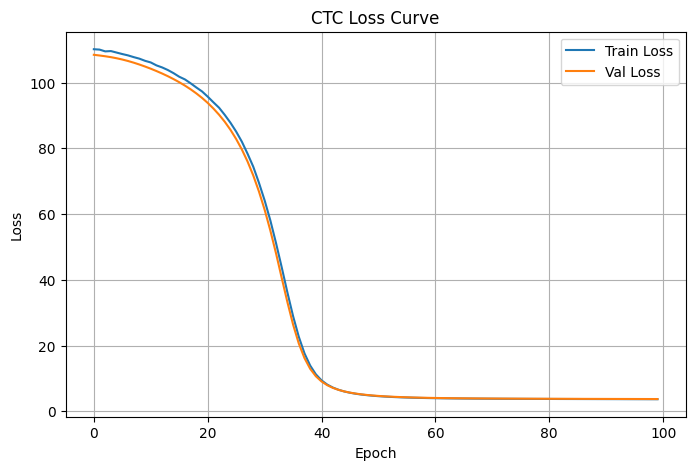

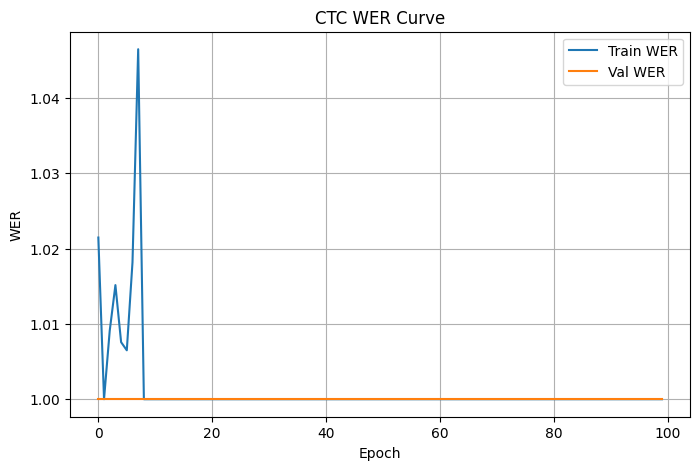

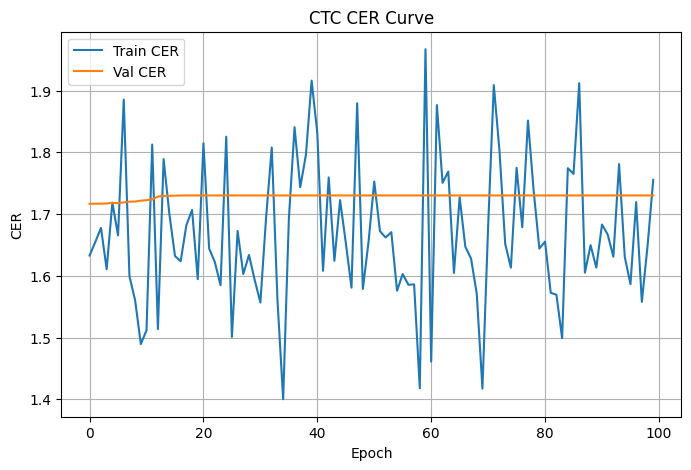

In [32]:
ctc_results = evaluate_and_plot_model(
    model=model_ctc,
    test_loader=test_loader,
    loss_fn=loss_fn_ctc,
    index_to_char=index_to_char,
    device=device,
    blank_idx=char_to_index['|'],
    use_beam=True,
    beam_width=5,
    model_type="ctc",
    train_losses=ctc_train_loss,
    val_losses=ctc_val_loss,
    train_wer=ctc_train_wer,
    val_wer=ctc_val_wer,
    train_cer=ctc_train_cer,
    val_cer=ctc_val_cer
)


[Test – RNNT] Loss: 3.7030 | WER: 1.0000 | CER: 1.0000


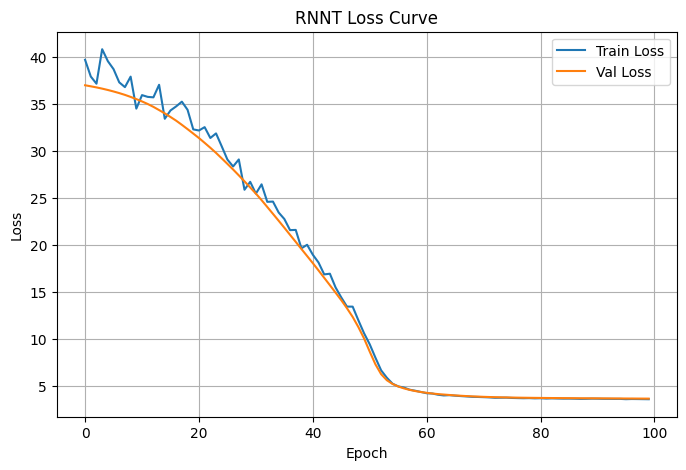

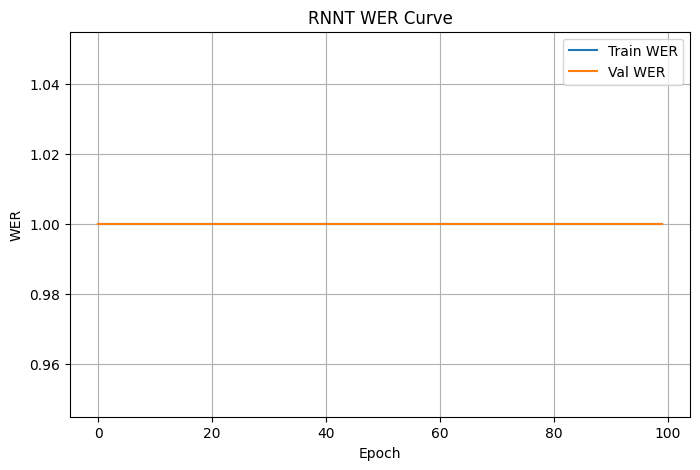

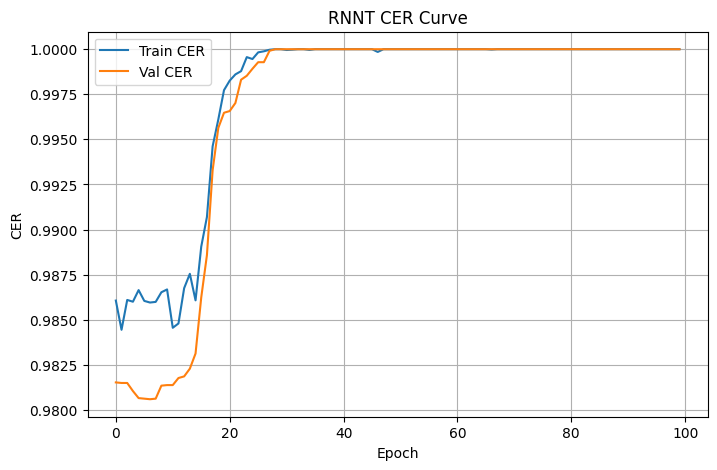

In [33]:
rnnt_results = evaluate_and_plot_model(
    model=model_rnnt,
    test_loader=test_loader,
    loss_fn=loss_fn_rnnt,
    index_to_char=index_to_char,
    device='cuda',
    blank_idx=char_to_index['|'],
    use_beam=True,
    beam_width=5,
    model_type="rnnt",
    train_losses=rnnt_train_loss,
    val_losses=rnnt_val_loss,
    train_wer=rnnt_train_wer,
    val_wer=rnnt_val_wer,
    train_cer=rnnt_train_cer,
    val_cer=rnnt_val_cer
)
